### Loading

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder.getOrCreate()

Both textual and tabular data fit seamlessly into the data frame structure. Let's see how to use PySpark with hierarchical JSON data.

When it's said that JSON is hierarchical data, it means that JSON (JavaScript Object Notation) organizes data in a hierarchical or tree-like structure. In JSON:

* Data is organized into key-value pairs.
* Values can be simple data types (strings, numbers, booleans, null) or complex data structures (objects or arrays).
* Objects can contain other objects or arrays, allowing for nested structures.
* This hierarchical structure enables representing complex relationships and organizing data in a logical and structured manner.
* JSON's hierarchical nature makes it suitable for representing a wide range of data types and data structures, commonly used in web development, APIs, and data interchange scenarios.

The keys of a JSON object must be strings

In [3]:
path = "/".join("\sparkdata\DataAnalysisWithPythonAndPySpark-Data\shows".split("\\"))

In [4]:
#Every JSON document starts with a bracket, which represents the root object. 
#Subsequent bracket pairs represent nested objects.
# We can think of JSON files as Python dictionaries

{
    "id": 143, #Every element in a JSON document is a key-value pair, just like in a Python dictionary. In JSON, every key must be a string.
    "name": "Silicon Valley", #Values can be scalar values, such as (quoted) strings, numerical values, Boolean (true/false) values, or null values (Python’s None) 
    "type": "Scripted",
    "language": "English",
    "genres": [
        "Comedy"
    ],
    "network": {
        "id": 8,
        "name": "HBO",
        "country": { #Values can also be complex, such as an array (akin to Python lists), using the square bracket, or even an object, using the bracket 
            "name": "United States",
            "code": "US",
            "timezone": "America/New_York"
        }
    }
}

{'id': 143,
 'name': 'Silicon Valley',
 'type': 'Scripted',
 'language': 'English',
 'genres': ['Comedy'],
 'network': {'id': 8,
  'name': 'HBO',
  'country': {'name': 'United States',
   'code': 'US',
   'timezone': 'America/New_York'}}}

In [5]:
import json

json_sample = """{
    "id": 143, 
    "name": "Silicon Valley",  
    "type": "Scripted",
    "language": "English",
    "genres": [
        "Comedy"
    ],
    "network": {
        "id": 8,
        "name": "HBO",
        "country": { 
            "name": "United States",
            "code": "US",
            "timezone": "America/New_York"
        }
    }
}"""

In [6]:
document = json.loads(json_sample)

In [7]:
print(document)

{'id': 143, 'name': 'Silicon Valley', 'type': 'Scripted', 'language': 'English', 'genres': ['Comedy'], 'network': {'id': 8, 'name': 'HBO', 'country': {'name': 'United States', 'code': 'US', 'timezone': 'America/New_York'}}}


In [8]:
type(document)

dict

### Reading JSON data in PySpark

In [6]:
shows = spark.read.json(path+"/shows-silicon-valley.json")
#No optional parameters

In [7]:
shows.count()

1

In [8]:
three_shows = spark.read.json(path+"/*.json",multiLine=True)

In [63]:
three_shows.select(F.col("id")).show()

+---+
| id|
+---+
|722|
|169|
|143|
+---+



### Complex Data Types: array and map

Complex types in PySpark is data types _that contain other types_ - it introduces a new level of nesting in the data frame schema. In Python, we are talking about tuples, lists and dictionaries. In PySpark, we have array, map and struct.

In [10]:
shows.printSchema()

root
 |-- _embedded: struct (nullable = true)
 |    |-- episodes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _links: struct (nullable = true)
 |    |    |    |    |-- self: struct (nullable = true)
 |    |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |-- airdate: string (nullable = true)
 |    |    |    |-- airstamp: string (nullable = true)
 |    |    |    |-- airtime: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- image: struct (nullable = true)
 |    |    |    |    |-- medium: string (nullable = true)
 |    |    |    |    |-- original: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- number: long (nullable = true)
 |    |    |    |-- runtime: long (nullable = true)
 |    |    |    |-- season: long (nullable = true)
 |    |    |    |-- summary: string (nullable = true)
 |    |    |    |-- url: string (nullable = true

In [11]:
## keys from root are parsed as columns
print(shows.columns)

['_embedded', '_links', 'externals', 'genres', 'id', 'image', 'language', 'name', 'network', 'officialSite', 'premiered', 'rating', 'runtime', 'schedule', 'status', 'summary', 'type', 'updated', 'url', 'webChannel', 'weight']


### The array type

Similar to the Python list, but with one caveat: PySpark arrays contains values __of the same type__. PySpark will not raise an error if you try to read an array-type column with multiple types. Instead, it will simply default to the lowest common denominator, usually the string. This way, you don’t lose any data, but you will get a surprise later if your code expects an array of another type 

In [12]:
array_subset = shows.select(F.col("name"),F.col("genres"))

In [13]:
array_subset.show()

+--------------+--------+
|          name|  genres|
+--------------+--------+
|Silicon Valley|[Comedy]|
+--------------+--------+



We need to extract the values within the array. Arrays are zero-indexed when retrieving
elements inside, just like Python lists. Unlike Python lists, passing an index that would
go beyond the content of the list returns null.

In [14]:
# ways of fecthing value from array
array_subset = array_subset.select(
    "name",
    array_subset.genres[0].alias("dot_and_index"),
    
    F.col("genres")[0].alias("col_and_index"),
    
    array_subset.genres.getItem(0).alias("dot_and_method"),
    
    F.col("genres").getItem(0).alias("col_and_method"),
)

In [15]:
array_subset.show()

+--------------+-------------+-------------+--------------+--------------+
|          name|dot_and_index|col_and_index|dot_and_method|col_and_method|
+--------------+-------------+-------------+--------------+--------------+
|Silicon Valley|       Comedy|       Comedy|        Comedy|        Comedy|
+--------------+-------------+-------------+--------------+--------------+



Although the square bracket approach looks very pythonic, you
can’t use it as a slicing tool. PySpark will accept only one integer as an index,
so for example array_subset.genres[0:10] would fail. PySpark’s array functions—available in the pyspark.sql.functions module—are
almost all prefixed with the array_ keyword (check API documentation)

In [16]:

## array and array_repeat
array_subset_repeated = array_subset.select(
    "name",
    F.lit("Comedy").alias("one"),
    F.lit("Horror").alias("two"),
    F.lit("Drama").alias("three"),
    F.col("dot_and_index")
).select(
    "name",
    F.array("one","two","three").alias("Some Genres"),
    F.array_repeat("dot_and_index",5).alias("Repeated_Genres")
)

In [17]:
array_subset_repeated.show(5,False)

+--------------+-----------------------+----------------------------------------+
|name          |Some Genres            |Repeated_Genres                         |
+--------------+-----------------------+----------------------------------------+
|Silicon Valley|[Comedy, Horror, Drama]|[Comedy, Comedy, Comedy, Comedy, Comedy]|
+--------------+-----------------------+----------------------------------------+



In [18]:
## size 
array_subset_repeated.select(
"name", F.size("Some Genres"), F.size("Repeated_Genres")
).show()

+--------------+-----------------+---------------------+
|          name|size(Some Genres)|size(Repeated_Genres)|
+--------------+-----------------+---------------------+
|Silicon Valley|                3|                    5|
+--------------+-----------------+---------------------+



In [19]:
# array_distinct
array_subset_repeated.select(
"name",
F.array_distinct("Some Genres"),
F.array_distinct("Repeated_Genres"),
).show(1, False)

+--------------+---------------------------+-------------------------------+
|name          |array_distinct(Some Genres)|array_distinct(Repeated_Genres)|
+--------------+---------------------------+-------------------------------+
|Silicon Valley|[Comedy, Horror, Drama]    |[Comedy]                       |
+--------------+---------------------------+-------------------------------+



In [20]:
#array_intersect
array_subset_repeated = array_subset_repeated.select(
"name",
F.array_intersect("Some Genres", "Repeated_Genres").alias(
"Genres"
),
)

In [21]:
array_subset_repeated.show()

+--------------+--------+
|          name|  Genres|
+--------------+--------+
|Silicon Valley|[Comedy]|
+--------------+--------+



### The map type

less common column type: JSON files don't yield columns of type map. It's similar to the Python dictionary, yet again its key values have to be of the same type, and values as well.

In [22]:
columns = ["name", "language", "type"]

shows_map = shows.select(
    *[F.lit(column) for column in columns],
    F.array(*columns).alias("values"),
)

shows_map = shows_map.select(F.array(*columns).alias("keys"), "values")

shows_map = shows_map.select(
    F.map_from_arrays("keys", "values").alias("mapped")
)
shows_map.printSchema()

root
 |-- mapped: map (nullable = false)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)



In [23]:
columns = ["name", "language", "type"]

shows_map = shows.select(
    *[F.lit(column) for column in columns],
    F.array(*columns).alias("values"), #gets values from columns list, assign the right column on shows, get the value back and put it in an array.
)

shows_map = shows_map.select(F.array(*columns).alias("keys"), "values")

shows_map = shows_map.select(
    F.map_from_arrays("keys", "values").alias("mapped")
)

shows_map.printSchema()

root
 |-- mapped: map (nullable = false)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)



In [24]:
## different ways to show mapped
shows_map.select(
    F.col("mapped.name"),
    F.col("mapped")["name"],
    shows_map.mapped["name"],
).show()

+--------------+--------------+--------------+
|          name|  mapped[name]|  mapped[name]|
+--------------+--------------+--------------+
|Silicon Valley|Silicon Valley|Silicon Valley|
+--------------+--------------+--------------+



### The struct type

Similar to a JSON object: keys are strings and the records can be different types. What differentiates it from map and array is that the number of fields and their names are known ahead of time. The array and the map enforce the types of the values, but not their numbers or names. The struct allows for more versatility of types, as long as you name each field and provide the type ahead of time.

In [25]:
shows.select("schedule").printSchema()

root
 |-- schedule: struct (nullable = true)
 |    |-- days: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- time: string (nullable = true)



In [26]:
shows.select(F.col("_embedded")).printSchema()

root
 |-- _embedded: struct (nullable = true)
 |    |-- episodes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _links: struct (nullable = true)
 |    |    |    |    |-- self: struct (nullable = true)
 |    |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |-- airdate: string (nullable = true)
 |    |    |    |-- airstamp: string (nullable = true)
 |    |    |    |-- airtime: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- image: struct (nullable = true)
 |    |    |    |    |-- medium: string (nullable = true)
 |    |    |    |    |-- original: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- number: long (nullable = true)
 |    |    |    |-- runtime: long (nullable = true)
 |    |    |    |-- season: long (nullable = true)
 |    |    |    |-- summary: string (nullable = true)
 |    |    |    |-- url: string (nullable = true

In [27]:
shows_clean = shows.withColumn(
    "episodes", F.col("_embedded.episodes")
).drop("_embedded")

In [28]:
shows_clean.printSchema()

root
 |-- _links: struct (nullable = true)
 |    |-- previousepisode: struct (nullable = true)
 |    |    |-- href: string (nullable = true)
 |    |-- self: struct (nullable = true)
 |    |    |-- href: string (nullable = true)
 |-- externals: struct (nullable = true)
 |    |-- imdb: string (nullable = true)
 |    |-- thetvdb: long (nullable = true)
 |    |-- tvrage: long (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- medium: string (nullable = true)
 |    |-- original: string (nullable = true)
 |-- language: string (nullable = true)
 |-- name: string (nullable = true)
 |-- network: struct (nullable = true)
 |    |-- country: struct (nullable = true)
 |    |    |-- code: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- timezone: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nul

### Building and using the data frame schema

The data types we use to build a schema are located in the pyspark.sql.types
module.

#### Base blocks

In [29]:
import pyspark.sql.types as T

two kinds of objects:
* _types_ object
with CamelCase syntax - ValueType(), LongType(), DecimalType(precision,scale). Complex types, such
as the array and the map, take the types of their values directly in the constructor:

ArrayType(StringType()), MapType(StringType(),LongType()))

* _field_ object
StructField(). A StructType() can contain an arbitraty number of named fields. __A StructType() takes a list of StructField()'s__.

four parameters: two mandatory
- name - string
- dataType - type object
- (optional) _nullable_ - field can be null or not
- (optional) _metadata_ - dictionary will information (used in ML pipelines)


If you provide a reduced schema—meaning you only define a subset of
the fields—PySpark will only read the defined fields. In the case where you
only need a subset of columns/fields from a very wide data frame, you can
save a significant amount of time!

In [30]:
shows.select(F.col("_embedded.episodes")).printSchema()

root
 |-- episodes: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- _links: struct (nullable = true)
 |    |    |    |-- self: struct (nullable = true)
 |    |    |    |    |-- href: string (nullable = true)
 |    |    |-- airdate: string (nullable = true)
 |    |    |-- airstamp: string (nullable = true)
 |    |    |-- airtime: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- image: struct (nullable = true)
 |    |    |    |-- medium: string (nullable = true)
 |    |    |    |-- original: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- number: long (nullable = true)
 |    |    |-- runtime: long (nullable = true)
 |    |    |-- season: long (nullable = true)
 |    |    |-- summary: string (nullable = true)
 |    |    |-- url: string (nullable = true)



In [31]:
episode_links_schema = T.StructType(
    [
        T.StructField(
            "self", T.StructType([T.StructField("href",T.StringType())])
        )
    ]
)

episode_image_schema = T.StructType(
    [
        T.StructField("medium",T.StringType()),
        T.StructField("original",T.StringType())
    ]
)

episode_schema = T.StructType(
    [
        T.StructField("_links", episode_links_schema),
        T.StructField("airdate", T.DateType()),
        T.StructField("airstamp", T.TimestampType()),
        T.StructField("airtime", T.StringType()),
        T.StructField("id", T.StringType()),
        T.StructField("image", episode_image_schema),
        T.StructField("name", T.StringType()),
        T.StructField("number", T.LongType()),
        T.StructField("runtime", T.LongType()),
        T.StructField("season", T.LongType()),
        T.StructField("summary", T.StringType()),
        T.StructField("url", T.StringType()),
    ]
)

In [32]:
embedded_schema = T.StructType(
    [
        T.StructField(
            "_embedded",
            T.StructType(
                [
                    T.StructField(
                    "episodes", T.ArrayType(episode_schema)
                    )
                ]
            ),
        )
    ]
)

#### Reading a JSON document with a strict schema in place

Reading JSON files while enforcing a precise schema. It also provides a better performance, as _inferSchema_ requires a pre-read of the data.

If we are facing a nonstandard date or timestamp format, you’ll need to pass the right format to dateFormat or timestampFormat. The format grammar is available on the official Spark documentation website.

In [39]:
shows_with_schema = spark.read.json(
    path+"/shows-silicon-valley.json",
    schema=embedded_schema,
    mode="FAILFAST", ## Df crashes if schema is incompatible
)

In [38]:
shows_with_schema.printSchema()

root
 |-- _embedded: struct (nullable = true)
 |    |-- episodes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _links: struct (nullable = true)
 |    |    |    |    |-- self: struct (nullable = true)
 |    |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |-- airdate: date (nullable = true)
 |    |    |    |-- airstamp: timestamp (nullable = true)
 |    |    |    |-- airtime: string (nullable = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- image: struct (nullable = true)
 |    |    |    |    |-- medium: string (nullable = true)
 |    |    |    |    |-- original: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- number: long (nullable = true)
 |    |    |    |-- runtime: long (nullable = true)
 |    |    |    |-- season: long (nullable = true)
 |    |    |    |-- summary: string (nullable = true)
 |    |    |    |-- url: string (nullable = t

In [41]:
for column in ["airdate", "airstamp"]:
    shows.select(f"_embedded.episodes.{column}").select(
    F.explode(column)
).show(5)

+----------+
|       col|
+----------+
|2014-04-06|
|2014-04-13|
|2014-04-20|
|2014-04-27|
|2014-05-04|
+----------+
only showing top 5 rows

+--------------------+
|                 col|
+--------------------+
|2014-04-07T02:00:...|
|2014-04-14T02:00:...|
|2014-04-21T02:00:...|
|2014-04-28T02:00:...|
|2014-05-05T02:00:...|
+--------------------+
only showing top 5 rows



#### Going full circle: Specifying your schemas in JSON

In [42]:
import pprint

pprint.pprint(
    shows_with_schema.select(
        F.explode("_embedded.episodes").alias("episode")
    )
    .select("episode.airtime")
    .schema.jsonValue()
)

{'fields': [{'metadata': {},
             'name': 'airtime',
             'nullable': True,
             'type': 'string'}],
 'type': 'struct'}


In [45]:
pprint.pprint(
    T.StructField("array_example", T.ArrayType(T.StringType())).jsonValue()
)

{'metadata': {},
 'name': 'array_example',
 'nullable': True,
 'type': {'containsNull': True, 'elementType': 'string', 'type': 'array'}}


In [46]:
pprint.pprint(
    T.StructField(
        "map_example", T.MapType(T.StringType(), T.LongType())
    ).jsonValue()
)

{'metadata': {},
 'name': 'map_example',
 'nullable': True,
 'type': {'keyType': 'string',
          'type': 'map',
          'valueContainsNull': True,
          'valueType': 'long'}}


In [47]:
pprint.pprint(
    T.StructType(
        [
            T.StructField(
                "map_example", T.MapType(T.StringType(), T.LongType())
            ),
            T.StructField("array_example", T.ArrayType(T.StringType())),
        ]
    ).jsonValue()
)

{'fields': [{'metadata': {},
             'name': 'map_example',
             'nullable': True,
             'type': {'keyType': 'string',
                      'type': 'map',
                      'valueContainsNull': True,
                      'valueType': 'long'}},
            {'metadata': {},
             'name': 'array_example',
             'nullable': True,
             'type': {'containsNull': True,
                      'elementType': 'string',
                      'type': 'array'}}],
 'type': 'struct'}


#### Making sure our JSON schema is consistent with what we are using

In [48]:
other_shows_schema = T.StructType.fromJson(
    json.loads(shows_with_schema.schema.json())
)

In [49]:
print(other_shows_schema == shows_with_schema.schema) 

True


Being able to serialize the schema of our dataframe is great to help having consistent and predictable data.

#### Reducing duplicate data with complex data types

When looking at a new table (or a data frame), what does each
record contain? Another way to approach this question is by completing the following
sentence: each record contains a single ____________. (Primary key)

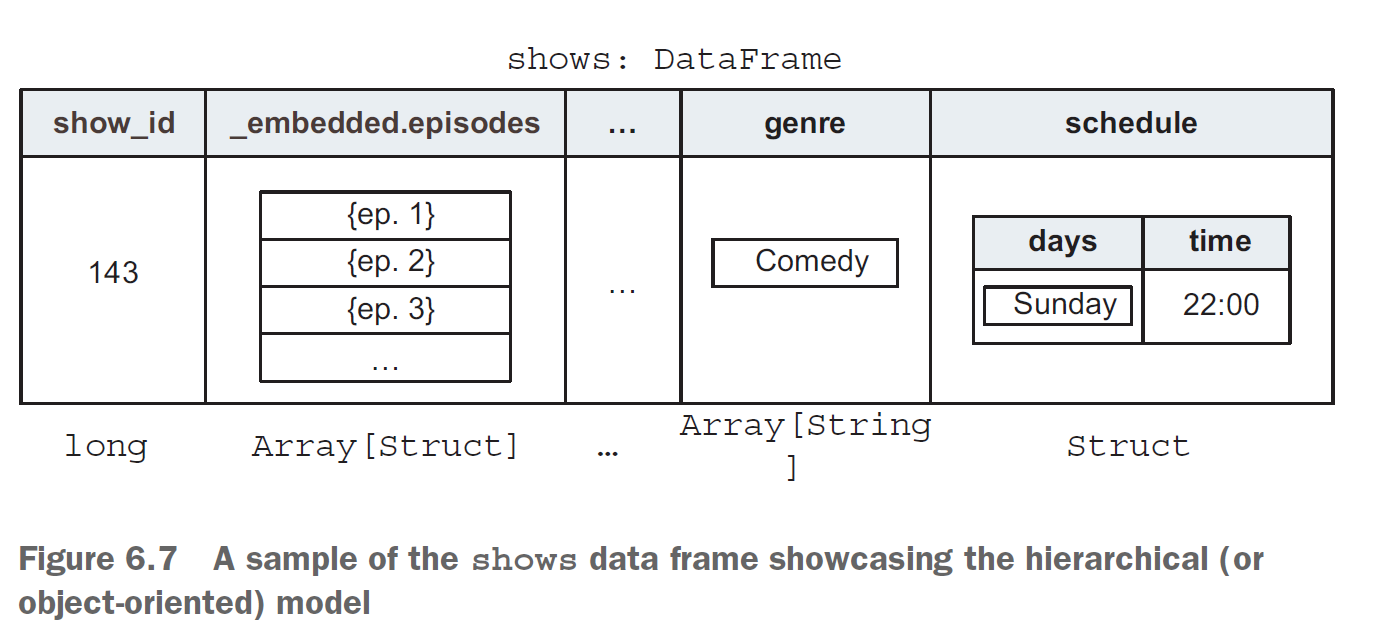

#### Explode and Collect

Going from hierarchical to tabular and back.

In [50]:
episodes = shows.select(
    "id", F.explode("_embedded.episodes").alias("episodes")
)
episodes.show(5, truncate=70)

+---+----------------------------------------------------------------------+
| id|                                                              episodes|
+---+----------------------------------------------------------------------+
|143|{{{http://api.tvmaze.com/episodes/10897}}, 2014-04-06, 2014-04-07T0...|
|143|{{{http://api.tvmaze.com/episodes/10898}}, 2014-04-13, 2014-04-14T0...|
|143|{{{http://api.tvmaze.com/episodes/10899}}, 2014-04-20, 2014-04-21T0...|
|143|{{{http://api.tvmaze.com/episodes/10900}}, 2014-04-27, 2014-04-28T0...|
|143|{{{http://api.tvmaze.com/episodes/10901}}, 2014-05-04, 2014-05-05T0...|
+---+----------------------------------------------------------------------+
only showing top 5 rows



Explode can also happen with maps: the keys and values will be exploded in two different
fields.

In [53]:
episode_name_id = shows.select(
    F.map_from_arrays(
        F.col("_embedded.episodes.id"), F.col("_embedded.episodes.name")
    ).alias("name_id")
)

episode_name_id.show(5,10)

episode_name_id = episode_name_id.select(
    F.posexplode("name_id").alias("position", "id", "name")
)

episode_name_id.show(5)

+----------+
|   name_id|
+----------+
|{10897 ...|
+----------+

+--------+-----+--------------------+
|position|   id|                name|
+--------+-----+--------------------+
|       0|10897|Minimum Viable Pr...|
|       1|10898|       The Cap Table|
|       2|10899|Articles of Incor...|
|       3|10900|    Fiduciary Duties|
|       4|10901|      Signaling Risk|
+--------+-----+--------------------+
only showing top 5 rows



Both explode() and posexplode() will skip any null values in the array or the map. If you want to have null as records, you can use explode_outer() or posexplode_outer() the same way.

In [55]:
# collecting records into a complex column: collect_list() & collect_set().

collected = episodes.groupby("id").agg(
    F.collect_list("episodes").alias("episodes")
)

collected.count()


1

In [56]:
collected.printSchema()

root
 |-- id: long (nullable = true)
 |-- episodes: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- _links: struct (nullable = true)
 |    |    |    |-- self: struct (nullable = true)
 |    |    |    |    |-- href: string (nullable = true)
 |    |    |-- airdate: string (nullable = true)
 |    |    |-- airstamp: string (nullable = true)
 |    |    |-- airtime: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- image: struct (nullable = true)
 |    |    |    |-- medium: string (nullable = true)
 |    |    |    |-- original: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- number: long (nullable = true)
 |    |    |-- runtime: long (nullable = true)
 |    |    |-- season: long (nullable = true)
 |    |    |-- summary: string (nullable = true)
 |    |    |-- url: string (nullable = true)



#### Building your own hierarchies: Struct as a function


To create a struct, we use the struct() function from the pyspark.sql.functions
module. This function takes a number of columns as parameters (just like select())
and returns a struct column containing the columns passed as parameters as fields.

In [57]:
struct_ex = shows.select(
    F.struct(
        F.col("status"), F.col("weight"), F.lit(True).alias("has_watched")
    ).alias("info")
)

In [58]:
struct_ex.show()

+-----------------+
|             info|
+-----------------+
|{Ended, 96, true}|
+-----------------+



In [59]:
struct_ex.printSchema()

root
 |-- info: struct (nullable = false)
 |    |-- status: string (nullable = true)
 |    |-- weight: long (nullable = true)
 |    |-- has_watched: boolean (nullable = false)



### Exercises

Although much less common, you can create a data frame from a dictionary. Since
dictionaries are so close to JSON documents, build the schema for ingesting the following
dictionary. (Both JSON or PySpark schemas are valid here.)

In [67]:
dict_schema = T.StructType([
        T.StructField("one",T.LongType()),
        T.StructField("two",T.ArrayType(T.LongType()))
    ]
)

spark.createDataFrame([{"one": 1, "two": [1,2,3]}], schema=dict_schema)

DataFrame[one: bigint, two: array<bigint>]

Using three_shows, compute the time between the first and last episodes for each
show. Which show had the longest tenure?

In [77]:
three_shows.printSchema()

root
 |-- _embedded: struct (nullable = true)
 |    |-- episodes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _links: struct (nullable = true)
 |    |    |    |    |-- self: struct (nullable = true)
 |    |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |-- airdate: string (nullable = true)
 |    |    |    |-- airstamp: string (nullable = true)
 |    |    |    |-- airtime: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- image: struct (nullable = true)
 |    |    |    |    |-- medium: string (nullable = true)
 |    |    |    |    |-- original: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- number: long (nullable = true)
 |    |    |    |-- runtime: long (nullable = true)
 |    |    |    |-- season: long (nullable = true)
 |    |    |    |-- summary: string (nullable = true)
 |    |    |    |-- url: string (nullable = true

In [104]:
three_shows.select(
    F.col("name"),
    F.array_min(F.col("_embedded.episodes.airdate")).cast("date").alias("min"),
    F.array_max(F.col("_embedded.episodes.airdate")).cast("date").alias("max")
).select(F.col("name"),(F.col("max")-F.col("min")).alias("total_time")).show()

+----------------+-------------------+
|            name|         total_time|
+----------------+-------------------+
|The Golden Girls|INTERVAL '2429' DAY|
|    Breaking Bad|INTERVAL '2079' DAY|
|  Silicon Valley|INTERVAL '2072' DAY|
+----------------+-------------------+



Take the shows data frame and extract the air date and name of each episode in two
array columns.

In [114]:
three_shows.select(F.explode(F.map_from_arrays(F.col("_embedded.episodes.name"),F.col("_embedded.episodes.airdate")))).show()

+--------------------+----------+
|                 key|     value|
+--------------------+----------+
|      The Engagement|1985-09-14|
|Guess Who's Comin...|1985-09-21|
|      Rose the Prude|1985-09-28|
|          Transplant|1985-10-05|
|        The Triangle|1985-10-19|
|     On Golden Girls|1985-10-26|
|     The Competition|1985-11-02|
|            Break-In|1985-11-09|
|Blanche and the Y...|1985-11-16|
|        Heart Attack|1985-11-23|
|The Return of Dor...|1985-11-30|
|  The Custody Battle|1985-12-07|
|    A Little Romance|1985-12-14|
|    That Was No Lady|1985-12-21|
|  In a Bed of Rose's|1986-01-11|
|  The Truth Will Out|1986-01-18|
|       Nice and Easy|1986-02-01|
|       The Operation|1986-02-08|
|   Second Motherhood|1986-02-15|
|     Adult Education|1986-02-22|
+--------------------+----------+
only showing top 20 rows



Given the following data frame, create a new data frame that contains a single map
from one to square:



In [116]:
exo6_8 = spark.createDataFrame([[1, 2], [2, 4], [3, 9]], ["one", "square"])

In [117]:
exo6_8.show()

+---+------+
|one|square|
+---+------+
|  1|     2|
|  2|     4|
|  3|     9|
+---+------+



In [121]:
(exo6_8.groupby()
    .agg(
        F.collect_list("one").alias("one"),
        F.collect_list("square").alias("square"),
)
.show())

+---------+---------+
|      one|   square|
+---------+---------+
|[1, 2, 3]|[2, 4, 9]|
+---------+---------+



In [125]:
(exo6_8.groupby()
    .agg(
        F.collect_list("one").alias("one"),
        F.collect_list("square").alias("square"),
)
.select(F.map_from_arrays("one","square"))
).show(1,False)

+----------------------------+
|map_from_arrays(one, square)|
+----------------------------+
|{1 -> 2, 2 -> 4, 3 -> 9}    |
+----------------------------+

